In [1]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import sys
sys.path.insert(0, "..")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch

from scipy.io import wavfile
import pyworld
import pysptk

import IPython
from IPython.display import Audio

import librosa
import librosa.display

from nnmnkwii import preprocessing as P
from glob import glob
from os.path import join


In [3]:
import gantts
from hparams import vc as hp

import librosa
import librosa.display
import IPython
from IPython.display import Audio

/home/chander/installations/anaconda3/envs/work/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from os.path import join,basename
import numpy as np
data_dir = "/home/chander/installations/gantts/data/cmu_arctic_vc_ksp_bdl"
clb_wav_dir = "data/cmu_arctic/cmu_us_ksp_arctic/wav/" #source directory
slt_wav_dir = "data/cmu_arctic/cmu_us_bdl_arctic/wav/" #target directory 

data_mean = np.load(join(data_dir, "data_mean.npy"))
data_var = np.load(join(data_dir, "data_var.npy"))
data_std = np.sqrt(data_var)


In [5]:
hp.generator_params["in_dim"] = data_mean.shape[-1]
hp.generator_params["out_dim"] = data_mean.shape[-1]

In [6]:
fs = 16000
hop_length = int(fs * (hp.frame_period * 0.001))
fftlen = pyworld.get_cheaptrick_fft_size(fs)
static_dim = hp.order

model_in2out = getattr(gantts.models, hp.generator)(**hp.generator_params)
print(model_in2out)

checkpoint_path = "/home/chander/installations/gantts/checkpoints/ksp_bdl/baseline/checkpoint_epoch200_Generator.pth"
print("Load checkpoint from: {}".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
model_in2out.load_state_dict(checkpoint["state_dict"])

In2OutHighwayNet(
  (relu): LeakyReLU(0.01, inplace)
  (sigmoid): Sigmoid()
  (T): Linear(in_features=59, out_features=59)
  (H): ModuleList(
    (0): Linear(in_features=177, out_features=512)
    (1): Linear(in_features=512, out_features=512)
    (2): Linear(in_features=512, out_features=512)
  )
  (last_linear): Linear(in_features=512, out_features=177)
  (dropout): Dropout(p=0.5)
)
Load checkpoint from: /home/chander/installations/gantts/checkpoints/ksp_bdl/baseline/checkpoint_epoch200_Generator.pth


In [7]:
model_gan = getattr(gantts.models, hp.generator)(**hp.generator_params)
print(model_gan)

checkpoint_path = "/home/chander/installations/gantts/checkpoints/ksp_bdl/gan/checkpoint_epoch200_Generator.pth"
print("Load checkpoint from: {}".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
model_gan.load_state_dict(checkpoint["state_dict"])

In2OutHighwayNet(
  (relu): LeakyReLU(0.01, inplace)
  (sigmoid): Sigmoid()
  (T): Linear(in_features=59, out_features=59)
  (H): ModuleList(
    (0): Linear(in_features=177, out_features=512)
    (1): Linear(in_features=512, out_features=512)
    (2): Linear(in_features=512, out_features=512)
  )
  (last_linear): Linear(in_features=512, out_features=177)
  (dropout): Dropout(p=0.5)
)
Load checkpoint from: /home/chander/installations/gantts/checkpoints/ksp_bdl/gan/checkpoint_epoch200_Generator.pth


In [8]:
from train import NPYDataSource
from os.path import splitext, join, abspath, basename, exists
from torch.autograd import Variable
def get_wav_files(data_dir, wav_dir, test=False):
    if test:
        files = NPYDataSource(join(data_dir, "X"), test=True).collect_files()
    else:
        files = NPYDataSource(join(data_dir, "X"), train=False).collect_files()

    wav_files = list(map(
        lambda f: join(wav_dir, splitext(basename(f))[0] + ".wav"), files))
    return wav_files

def test_vc_from_path(model, path, data_mean, data_std, diffvc=True):
    model.eval()

    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=hp.frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=hp.order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    static_dim = mc.shape[-1]
    mc = P.modspec_smoothing(mc, fs / hop_length, cutoff=50)
    mc = P.delta_features(mc, hp.windows).astype(np.float32)

    T = mc.shape[0]

    inputs = mc[:, :static_dim].copy()

    # Normalization
    mc_scaled = P.scale(mc, data_mean, data_std)

    mc_scaled = Variable(torch.from_numpy(mc_scaled))
    lengths = [len(mc_scaled)]

    # Add batch axis
    mc_scaled = mc_scaled.view(1, -1, mc_scaled.size(-1))

    # For MLPG
    R = unit_variance_mlpg_matrix(hp.windows, T)
    R = torch.from_numpy(R)

    # Apply model
    if model.include_parameter_generation():
        # Case: models include parameter generation in itself
        # Mulistream features cannot be used in this case
        y_hat, y_hat_static = model(mc_scaled, R, lengths=lengths)
    else:
        # Case: generic models (can be sequence model)
        assert hp.has_dynamic_features is not None
        y_hat = model(mc_scaled, lengths=lengths)
        y_hat_static = multi_stream_mlpg(
            y_hat, R, hp.stream_sizes, hp.has_dynamic_features)

    mc_static_pred = y_hat_static.data.cpu().numpy().reshape(-1, static_dim)

    # Denormalize
    mc_static_pred = P.inv_scale(
        mc_static_pred, data_mean[:static_dim], data_std[:static_dim])

    outputs = mc_static_pred.copy()

    if diffvc:
        mc_static_pred = mc_static_pred - mc[:, :static_dim]

    mc = np.hstack((c0[:, None], mc_static_pred))
    if diffvc:
        mc[:, 0] = 0  # remove power coefficients
        engine = Synthesizer(MLSADF(order=hp.order, alpha=alpha),
                             hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        fftlen = pyworld.get_cheaptrick_fft_size(fs)
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, hp.frame_period)

    return waveform, inputs, outputs


src_test_files = get_wav_files(data_dir, clb_wav_dir, test=True)
tgt_test_files = get_wav_files(data_dir, slt_wav_dir, test=True)

print('source files\n',src_test_files,'\n\n')
print ('target audio\n',tgt_test_files)


source files
 ['data/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0496.wav', 'data/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0497.wav', 'data/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0498.wav', 'data/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0499.wav', 'data/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0500.wav'] 


target audio
 ['data/cmu_arctic/cmu_us_bdl_arctic/wav/arctic_a0496.wav', 'data/cmu_arctic/cmu_us_bdl_arctic/wav/arctic_a0497.wav', 'data/cmu_arctic/cmu_us_bdl_arctic/wav/arctic_a0498.wav', 'data/cmu_arctic/cmu_us_bdl_arctic/wav/arctic_a0499.wav', 'data/cmu_arctic/cmu_us_bdl_arctic/wav/arctic_a0500.wav']


In [9]:

from nnmnkwii.paramgen import unit_variance_mlpg_matrix
from pysptk.synthesis import Synthesizer, MLSADF
for src_path, tgt_path in zip(src_test_files, tgt_test_files):
    fs, src_waveform = wavfile.read(src_path)
    fs, tgt_waveform = wavfile.read(tgt_path)
    
    in2out_waveform,_,_ = test_vc_from_path(model_in2out, src_path, data_mean, data_std, diffvc=True)
    gan_waveform,_,_ = test_vc_from_path(model_gan, src_path, data_mean, data_std, diffvc=True)
    
    print(basename(src_path), ": source, target, baseline, GAN")
    for x in [src_waveform, tgt_waveform, in2out_waveform, gan_waveform]:
        IPython.display.display(Audio(x, rate=fs))

arctic_a0496.wav : source, target, baseline, GAN


arctic_a0497.wav : source, target, baseline, GAN


arctic_a0498.wav : source, target, baseline, GAN


arctic_a0499.wav : source, target, baseline, GAN


arctic_a0500.wav : source, target, baseline, GAN


In [10]:
def compute_static_features(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=hp.frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=hp.order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    return mc
    
def vis_gv(src_path, tgt_path):    
    tgt_mgc = compute_static_features(tgt_path)
    waveform_in2out, _, mgc_in2out = test_vc_from_path(
        model_in2out, src_path, data_mean, data_std, diffvc=True)
    waveform_gan, _, mgc_gan = test_vc_from_path(
        model_gan, src_path, data_mean, data_std, diffvc=True)
    
    figure(figsize=(16,6))
    plot(np.var(tgt_mgc, axis=0), "--", linewidth=2, label="Target: global variances")
    plot(np.var(mgc_in2out, axis=0), linewidth=2, label="In2Out: global variances")
    plot(np.var(mgc_gan, axis=0), linewidth=2, label="GAN: global variances")
    legend(prop={"size": 18})
    yscale("log")
    xlim(0, static_dim)
    xlabel("Dimention", fontsize=16)
        
    fs, src_waveform = wavfile.read(src_path)
    fs, tgt_waveform = wavfile.read(tgt_path)
    
    for x, name in [(src_waveform, "Source waveform"),
                   #(tgt_waveform, "Target waveform"),
                   #(waveform_in2out, "In2Out"),
                   (waveform_gan, "GAN")]:
        print(name)
        IPython.display.display(Audio(x, rate=fs))

Source waveform


GAN


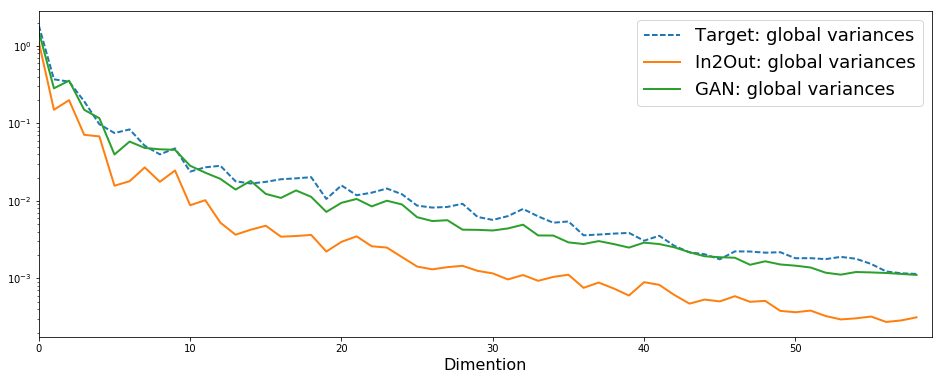

In [11]:
name = "arctic_a0050.wav"

src_path = join(clb_wav_dir, name)
tgt_path = join(slt_wav_dir, name)
vis_gv(src_path, tgt_path)

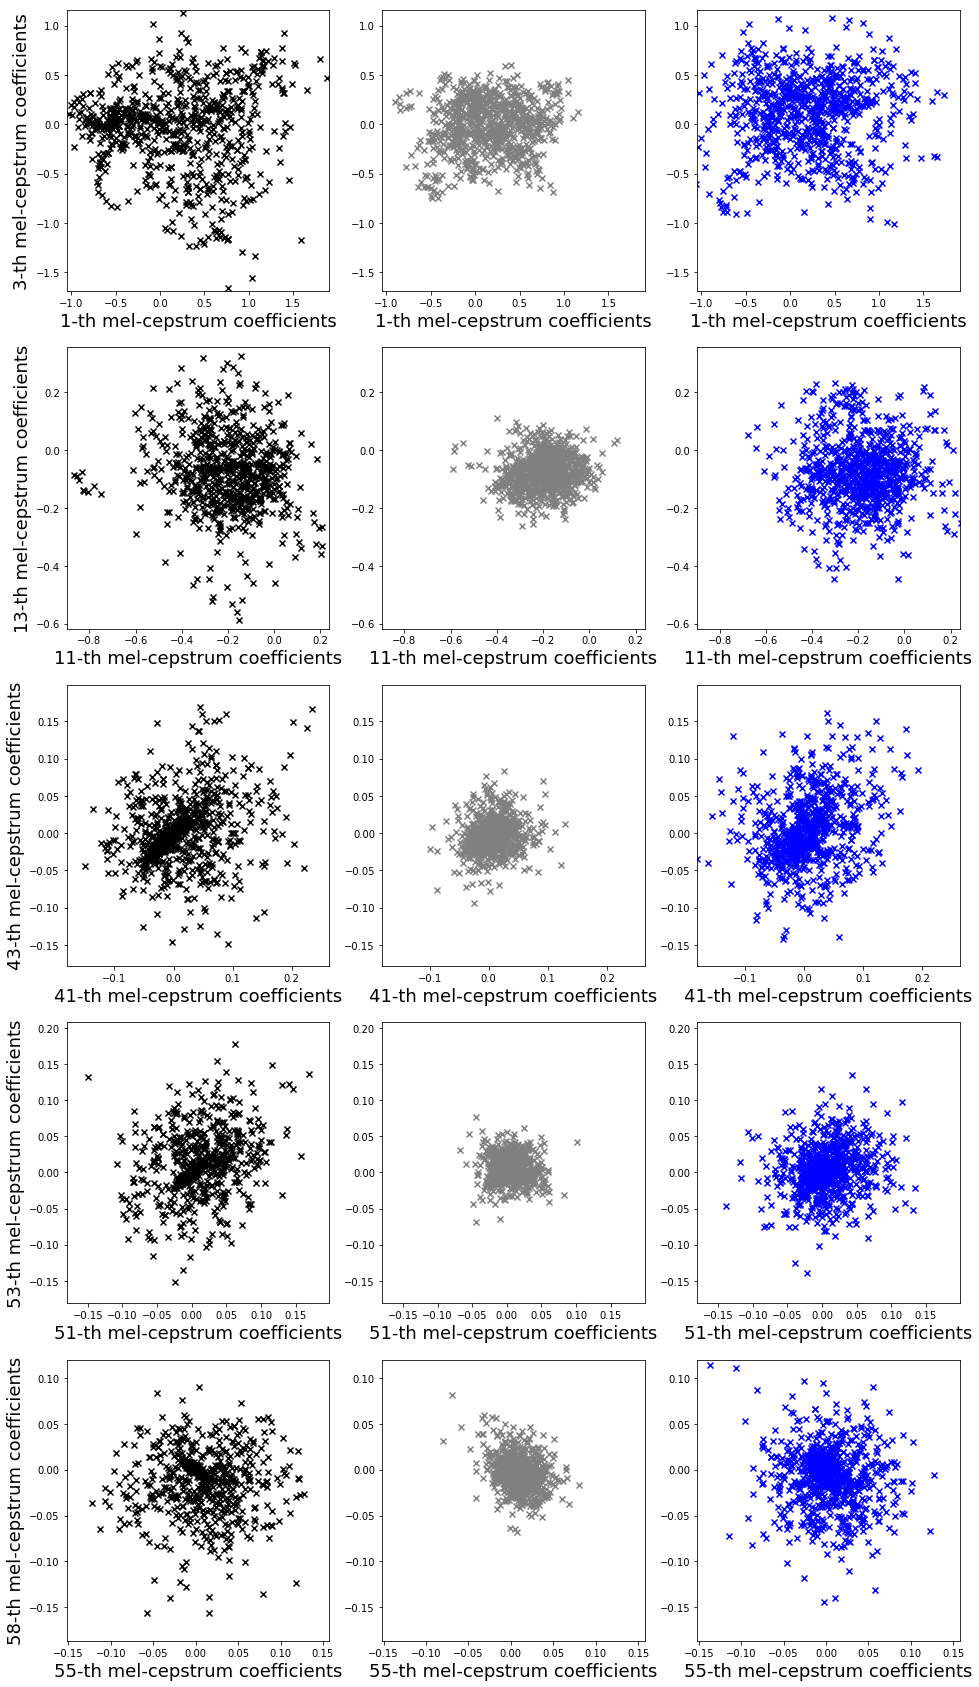

In [12]:
def scatter_plots(src_path, tgt_path):
    tgt_mgc = compute_static_features(tgt_path)
    _, _, mgc_in2out = test_vc_from_path(
        model_in2out, src_path, data_mean, data_std, diffvc=True)
    _, _, mgc_gan = test_vc_from_path(
        model_gan, src_path, data_mean, data_std, diffvc=True)

    dim_pairs = [(1, 3), (11, 13), (41, 43), (51, 53), (55, 58)]
    figure(figsize=(16,6*len(dim_pairs)))

    for pair_idx, (i, j) in enumerate(dim_pairs):
        for idx, features in enumerate([tgt_mgc, mgc_in2out, mgc_gan]):
            subplot(len(dim_pairs), 3, pair_idx*3 + 1+idx)
            c = "black" if idx == 0 else "gray" if idx == 1 else "blue"
            scatter(features[:,i], features[:,j], marker="x", c=c)            
            xlim(np.min(tgt_mgc[:,i])-0.03, np.max(tgt_mgc[:,i])+0.03)
            ylim(np.min(tgt_mgc[:,j])-0.03, np.max(tgt_mgc[:,j])+0.03)
            xlabel("{}-th mel-cepstrum coefficients".format(i), fontsize=18)
            if idx == 0:
                ylabel("{}-th mel-cepstrum coefficients".format(j), fontsize=18)
            
scatter_plots(src_path, tgt_path)